# Урок 9. Python применение продвинутых методов

In [2]:
import math
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats.power as smp
from statsmodels.stats.proportion import proportion_effectsize

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px

from tqdm.auto import tqdm  # будет показывать количество итераций

import warnings
warnings.filterwarnings('ignore')

## Проверка данных на нормальность

1. **Графические методы**: Оценка данных с использованием гистограммы и Quantile-Quantile-plot
2. **Статистические методы**: Критерии проверки нормальности распределения
    * Шапиро-Уилка при $n < 5000$
    * Колмогорова-Смирнова для любых выборок

Создадим выборку нормального распределения и распределения Стьюдента с 5-ю степенями свободы.

In [3]:
n = 250
x = stats.norm.rvs(size = n)
y = stats.t.rvs(size = n, df = 5)

### Гистограммы

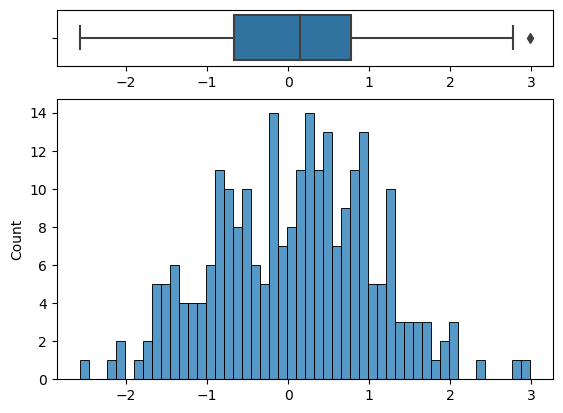

In [17]:
#fig = px.histogram(x, x=x, title='Нормальное распределение (x)', marginal = 'box')
#fig.show()

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2.5]})
sns.boxplot(x, ax=ax[0]);
sns.histplot(x, bins=50, ax=ax[1]);

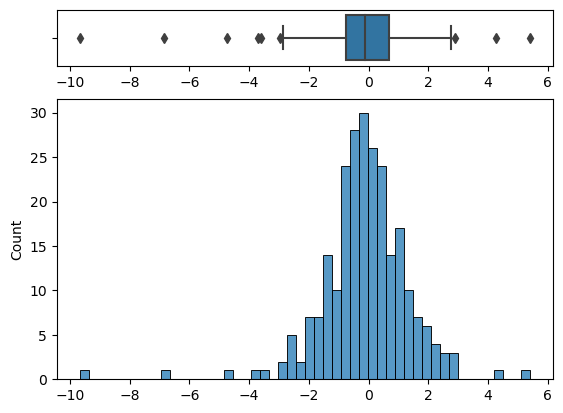

In [18]:
#fig = px.histogram(y, x=y, title='Распределение Стьюдента (y)', marginal = 'box')
#fig.show()

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2.5]})
sns.boxplot(y, ax=ax[0]);
sns.histplot(y, bins=50, ax=ax[1]);

### Quantile-Quantile-plot

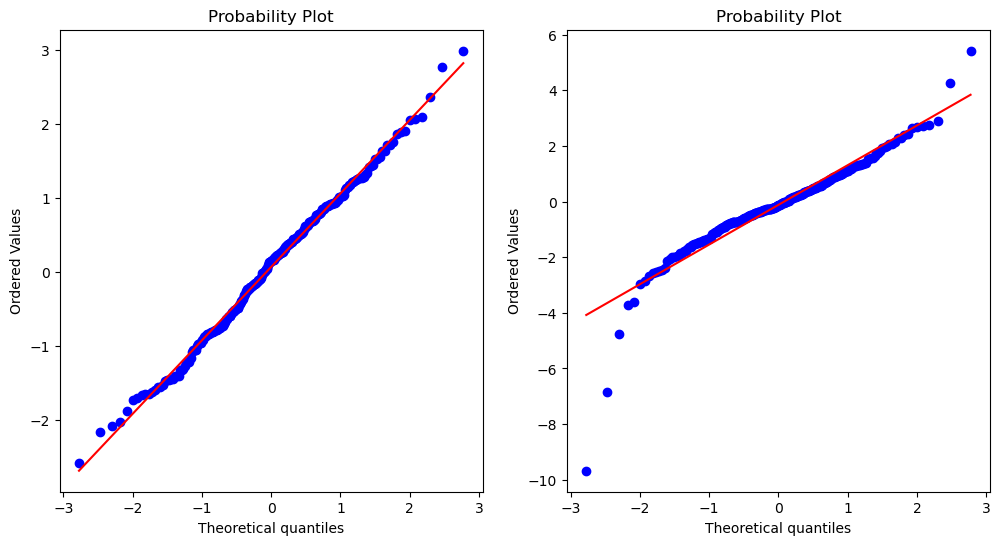

In [19]:
plt.figure(figsize = [6*2, 6])

plt.subplot(1, 2, 1)
norm = stats.probplot(x, dist="norm", plot=plt)

plt.subplot(1, 2, 2)
norm = stats.probplot(y, dist="norm", plot=plt)

### Тест Колмогорова-Смирнова

Для выборок любого размера.

$H_0$ - x взята из генеральной совокупности с нормальным распределением.\
$H_1$ - x взята из ген.совокупности с другим распределением.

Можно использовать для проверки любого другого распределения(Стьюдента, биномиального, коши, экспоненциального).

**При p-value > alpha: анализируемое распределение не отличается от нормального.**

In [20]:
stats.kstest(x, 'norm')

KstestResult(statistic=0.06621311426800602, pvalue=0.21341779667033878)

In [21]:
stats.kstest(y, 'norm')

KstestResult(statistic=0.06877234374687596, pvalue=0.17930746972924316)

Оба распределния **не** отличаются от нормального.

In [22]:
# Проверим принадлежность к экспоненциальному распределению
stats.kstest(x, 'expon')

KstestResult(statistic=0.4567972945688709, pvalue=3.3037647520933367e-48)

In [23]:
# Проверим принадлежность к биномиальному распределению
stats.kstest(x, 'binom', args=(1_500, 0.16))

KstestResult(statistic=1.0, pvalue=0.0)

Распределение точно отличается от экспоненциального и от биномиального.

### Тест Шапиро-Уилка
Является наиболее мощным для воборок до 5000 наблюдений.

$H_0$ - x взята из генеральной совокупности с нормальным распределением. \
$H_1$ - x взята из генеральной совокупности с другим распределением.

**При $p-value > \alpha$: анализируемое распределение не отличается от нормального.**

In [24]:
stats.shapiro(x)

ShapiroResult(statistic=0.9955223798751831, pvalue=0.685921847820282)

Распределение $x$ **не** отличается от нормального.

In [25]:
stats.shapiro(y)

ShapiroResult(statistic=0.9087813496589661, pvalue=3.322075947664871e-11)

Распределение $y$ отличается от нормального.

## Расчет мощности теста / расчет длительности эксперимента.

1. **статистические:**
    - Размер выборки (Effect size, ошибка 1 рода (FP), ошибка 2 рода (FN))
    - Дисперсия (дисперсия частично зашита в Effect size => чем больше дисперсия, тем больше нам нужно наблюдений)


2. **продуктовые:**
    - Сезонность (недельная / месячная / ...)
    - Метрика (тип метрики, окно закрытия метрики)

In [26]:
# Критерий пропорций (для кликов, конверсий)
alpha = 0.05
n = 450             # Количество наблюдений
p1, p2 = 0.5, 0.6           # Конверсии

Если мы предположим, что $p_1$ и $p_2$ представляют собой две пропорции, то effect_size представлен в виде:\
$h = φ_1 - φ_2 $, where $φ = 2 \arcsin(\sqrt{p_i})$

In [27]:
h = 2*math.asin(np.sqrt(p1)) - 2*math.asin(np.sqrt(p2))
h

-0.20135792079033066

In [28]:
h = proportion_effectsize(p1, p2)
h

-0.20135792079033066

In [29]:
# Мощность критерия для выборки из n элементов, если effect_size = h, alpha = 5%
power = smp.zt_ind_solve_power(effect_size=h, nobs1=n, alpha=alpha, alternative='two-sided')
power

0.8555200838742346

In [30]:
# Количество наблюдений, необходимое для заданного эффекта при alpha=5%, beta=85%
smp.zt_ind_solve_power(effect_size=h, alpha=alpha, power=power, alternative='two-sided')

449.9999999951084

In [31]:
# Величина эффекта effect_size при заданных alpha и beta
smp.zt_ind_solve_power(nobs1=n, alpha=alpha, power=power)

0.20135582707747696

In [32]:
effects = []
sample_sizes = []

for i in tqdm(range(10, 10_000)):
    effects.append(smp.tt_ind_solve_power(nobs1=i, alpha=alpha, power=power))
    sample_sizes.append(i)

  0%|          | 0/9990 [00:00<?, ?it/s]

In [33]:
df = pd.DataFrame({'effects': effects, 'sizes': sample_sizes})
df

,effects,sizes
0,1.428738,10
1,1.354278,11
2,1.290467,12
3,1.234970,13
4,1.186115,14
...,...,...
9985,0.042727,9995
9986,0.042725,9996
9987,0.042723,9997
9988,0.042721,9998


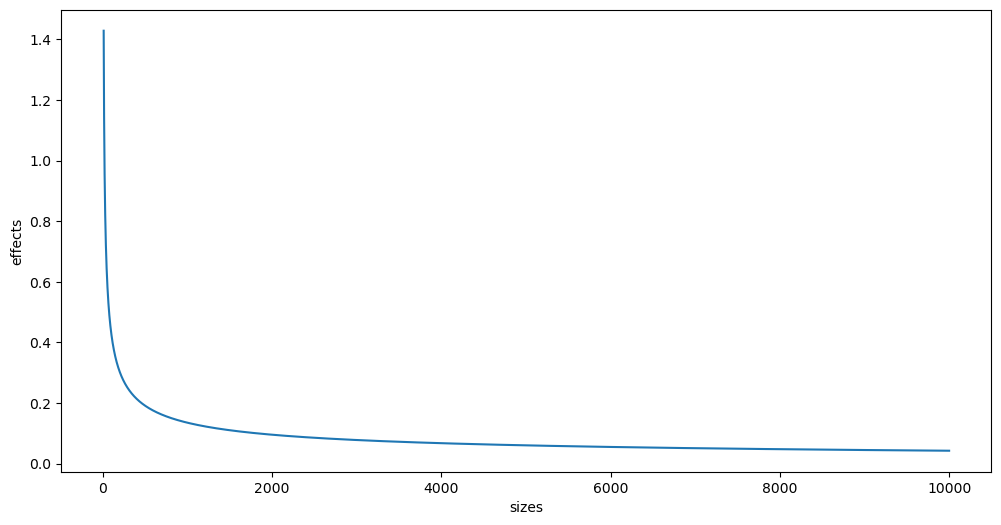

In [36]:
#fig = px.line(df, x='sizes', y='effects', title='effect vs sample size')
#fig.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='sizes', y='effects');

Чем меньше эффект, тем больше нам нужно количество наблюдений, чтобы его зафиксировать.

In [37]:
test_power = []
sample_sizes = []

for i in tqdm(range(10, 10_000)):
    test_power.append(smp.tt_ind_solve_power(nobs1=i, alpha=alpha, effect_size=0.1))
    sample_sizes.append(i)

  0%|          | 0/9990 [00:00<?, ?it/s]

In [38]:
df = pd.DataFrame({'power': test_power, 'sizes': sample_sizes })
df

,power,sizes
0,0.055161,10
1,0.055741,11
2,0.056320,12
3,0.056899,13
4,0.057479,14
...,...,...
9985,1.000000,9995
9986,1.000000,9996
9987,1.000000,9997
9988,1.000000,9998


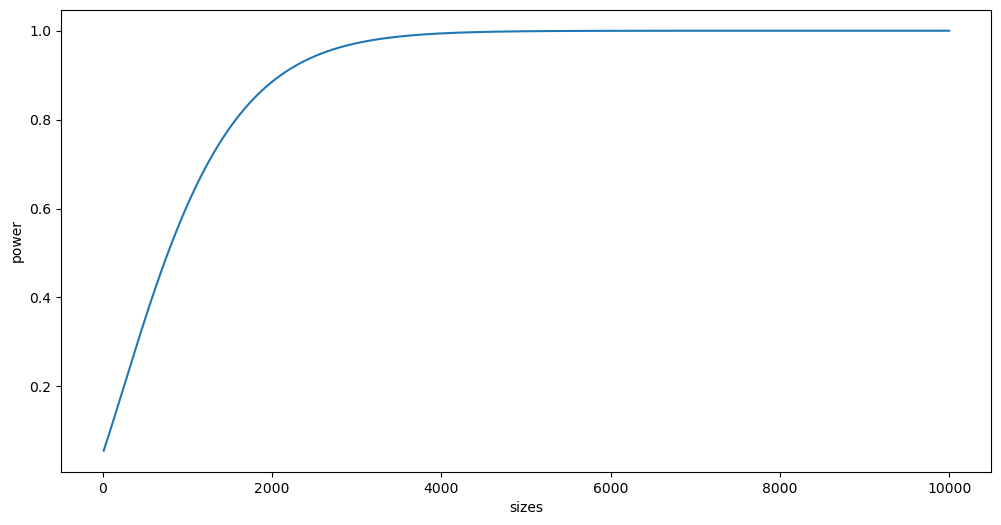

In [40]:
#fig = px.line(df, x='sizes', y='power', title='power vs sample size')
#fig.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='sizes', y='power');

При росте количества наблюдений, мощность увеличивается.

## Множественная проверка гипотез

In [41]:
n = 1000
rvs1 = stats.norm.rvs(loc=5, scale=10, size=n, random_state=0)
rvs2 = stats.norm.rvs(loc=6.5, scale=8, size=n, random_state=0)

In [42]:
def t_test_function(rvs, alpha, no_test):   # на вход: распределение, альфу и количество тестов.
    '''
    return: кол-во ошибок I рода (False Positive)
    '''
    counter=0
    for i in range(no_test):
        rvs_random = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=i+1)
        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)

    if pvalue <= alpha:
        counter += 1

    print(counter)

In [43]:
def bonferroni_correction_function(rvs, alpha, no_test):
    '''
    return: кол-во ошибок I рода (False Positive)
    '''
    alpha_bonferroni = alpha / no_test
    counter = 0
    for i in range(no_test):
        rvs_random = stats.norm.rvs(loc=5, scale=10, size=1000, random_state=i+1)
        statistic, pvalue = stats.ttest_ind(rvs, rvs_random, equal_var=False)

    if pvalue <= alpha_bonferroni:
        counter += 1

    print(counter)

In [44]:
t_test_function(rvs1, alpha=0.05, no_test=100)
t_test_function(rvs2, alpha=0.05, no_test=100)

bonferroni_correction_function(rvs1, alpha=0.05, no_test=100)
bonferroni_correction_function(rvs2, alpha=0.05, no_test=100)

0
1
0
0


## Bootstrap

[GitHub - facebookarchive/bootstrapped: Generate bootstrapped confidence intervals for A/B testing in Python.](https://github.com/facebookarchive/bootstrapped)

In [ ]:
#!pip install bootstrapped

#import bootstrapped.bootstrap as bs
#import bootstrapped.compare_functions as bs_compare
#import bootstrapped.stats_functions as bs_stats

In [ ]:
n = 11000
A = np.random.exponential(scale=1/0.002, size=n)
B = np.random.exponential(scale=1/0.00201, size=n)

df = pd.DataFrame({"A": A, "B": B})
df

In [ ]:
s1 = df.A.values
s2 = df.B.values

'''
b = bs.bootstrap_ab(s1, s2,
                    stat_func=bs_stats.mean,
                    compare_func=bs_compare.difference,
                    alpha=0.05,
                    num_iterations=10000)

print(b.lower_bound, b.upper_bound)
'''

In [ ]:
# Для стандартного отклонения
'''
v = bs.bootstrap_ab(s_1, s_2, 
                    stat_func=bs_stats.std, 
                    compare_func=bs_compare.difference,
                    alpha=0.05,
                    num_iterations=10000)

print(v.lower_bound, v.upper_bound)
'''

## Бакетирование

Разбивает данные на более управляемые части (сегменты или бакеты), чтобы ускорить последовательные чтения данных для последующих заданий. В один бакет попадают строчки таблицы, у которых совпадает значение хэш-функции, вычисленное по определенной колонке.

Способ привести распределение к нормальному и применить, например, ttest.

**Когда применяем**:
- сохранить информацию о дисперсии и среднем в выборке до трансформации
- привести к нормальному распределению

Возьмем кратное количество групп: например, 2000 (можно 300 или 600)

In [45]:
b = 2_000
n = 200_000

A = np.random.exponential(scale=1/0.002, size=n)
B = np.random.exponential(scale=1/0.00201, size=n) 

sample = pd.DataFrame({
    "metric": np.concatenate([A, B]),
    "group": ["A" for i in range(n)] + ["B" for i in range(n)],
    "bucket": [i for i in range(b)] * int(n * 2 / b)
})
sample

,metric,group,bucket
0,336.253521,A,0
1,332.272273,A,1
2,223.821816,A,2
3,392.671975,A,3
4,114.012844,A,4
...,...,...,...
399995,837.956591,B,1995
399996,325.152038,B,1996
399997,26.260688,B,1997
399998,64.572203,B,1998


In [46]:
df = sample.groupby(by=["bucket", "group"])["metric"].agg(mu=np.mean, sd=np.std).reset_index()
df

,bucket,group,mu,sd
0,0,A,430.983289,376.202953
1,0,B,463.408153,407.283275
2,1,A,521.864114,553.164801
3,1,B,479.590756,520.707502
4,2,A,502.855358,597.595431
...,...,...,...,...
3995,1997,B,501.242608,461.716023
3996,1998,A,471.200057,465.266659
3997,1998,B,464.119489,420.857962
3998,1999,A,518.286140,417.556294


In [47]:
# Сравним выборочное среднее и среднее по баккетам изначальное.
round(np.mean(sample["metric"]), 3) == round(np.mean(df["mu"]), 3)

True

In [48]:
np.var(sample["metric"]) / sample["metric"].shape[0]

0.6207056373169388

In [49]:
np.var(df["mu"]) / df["mu"].shape[0]

0.6289407404467792

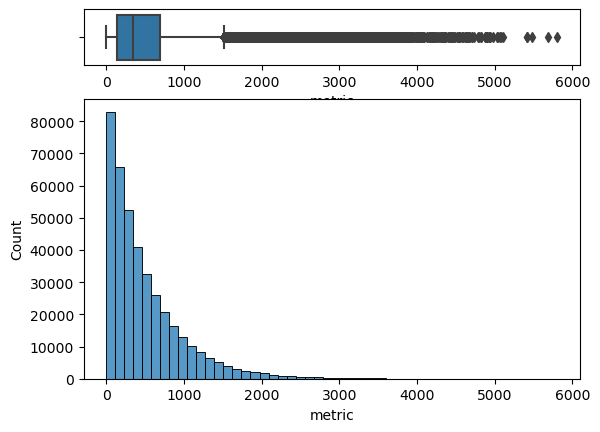

In [50]:
#fig = px.histogram(sample, x=sample.metric, title='x', marginal='box')
#fig.show()

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2.5]})
sns.boxplot(data=sample, x='metric', ax=ax[0]);
sns.histplot(data=sample, x='metric', bins=50, ax=ax[1]);

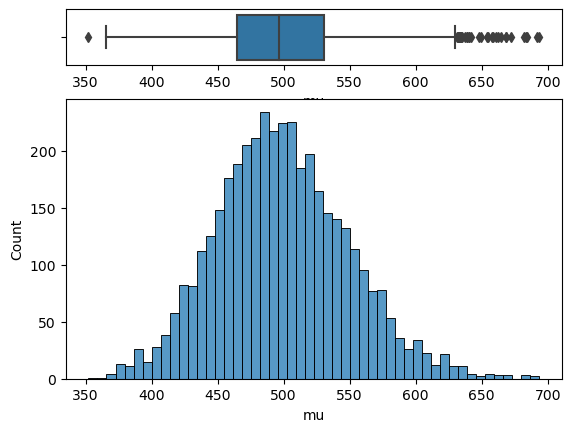

In [51]:
#fig = px.histogram(df, x=df.mu, title='x', marginal='box')
#fig.show()

fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.5, 2.5]})
sns.boxplot(data=df, x='mu', ax=ax[0]);
sns.histplot(data=df, x='mu', bins=50, ax=ax[1]);

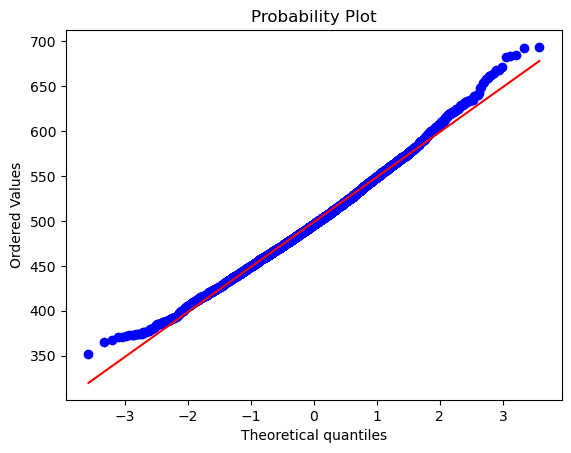

In [52]:
norm = stats.probplot(df.mu, dist="norm", plot=plt)

In [53]:
stats.kstest(df.mu, 'norm')

KstestResult(statistic=1.0, pvalue=0.0)

In [54]:
stats.shapiro(df.mu)

ShapiroResult(statistic=0.9948772192001343, pvalue=1.1972813018790163e-10)